## Import

In [30]:
import os
import json
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import sent_tokenize, word_tokenize, edit_distance
from nltk.tokenize import SyllableTokenizer
from lexicalrichness import LexicalRichness
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

## Metrics

### Word and Character count

In [31]:
def get_words_count(text):
    words = word_tokenize(text)
    return len(words)

### Flesch Reading Ease

In [32]:
def calculate_FRE_score(text:str, lang:str="fr") -> float:
    """Calculate Flesch Reading Ease per sentence

    en: 206.835 - 1.015 * (total_words/total_sentences) - 84.6 * (total_syllabes/total_words) 
    fr: 207 - 1.015 * (total_words/total_sentences) - 73.6 * (total_syllabes/total_words) 

    Args:
        text (str): a given text
    """

    x = 206.835
    y = 84.6
    total_words = 0
    total_syllabes = 0
    SSP = SyllableTokenizer()

    if lang=="fr":
        x = 207
        y = 73.6

    sentences = sent_tokenize(text)
    total_sentences = len(sentences)

    for sentence in sentences:
        words = word_tokenize(sentence)
        total_words += len(words)

        for word in words:
            syllabes = SSP.tokenize(word)
            total_syllabes += len(syllabes)
     
    return x - 1.015 * (total_words/total_sentences) - y * (total_syllabes/total_words)

### Lexical Richness

In [33]:

def calculate_LR(text:str, lang:str="fr") -> float:
    try:
        lex = LexicalRichness(text)
        lr = lex.mtld()
    except:
        lr = 0
    return lr 
        


### Levenshtein Distance

In [34]:
def calculate_edit_distance(fpath1, fpath2) -> float:
    eds_by_word = []
    eds_by_char = []
    num_lines = sum(1 for line in open(fpath1,'r', encoding="utf-8"))
    pbar = tqdm(total = num_lines, desc=f"file:{fpath1.split('/')[-1], fpath2.split('/')[-1]}")
    with open(fpath1, encoding="utf-8") as f1:
        with open(fpath2, encoding="utf-8") as f2:
            line1 = f1.readline()
            line2 = f2.readline()
            while line1:
                wordlist1 = word_tokenize(line1)
                wordlist2 = word_tokenize(line2)

                eds_by_word.append(edit_distance(wordlist1, wordlist2))
                eds_by_char.append(edit_distance(line1, line2))

                line1 = f1.readline()
                line2 = f2.readline()
                pbar.update(1)
    pbar.close()

    return eds_by_word, eds_by_char

### Get metrics

In [35]:
def get_metrics_from_file(fpath, lang="fr"):
    fre_scores = []
    lr_scores = []
    word_count = []

    num_lines = sum(1 for line in open(fpath,'r', encoding="utf-8"))
    pbar = tqdm(total = num_lines, desc=f"file:{fpath.split('/')[-1]}")
    with open(fpath, "r", encoding="utf-8") as f:
        line = f.readline()
        while line:
            fre_scores.append(calculate_FRE_score(line, lang))
            lr_scores.append(calculate_LR(line, lang))
            word_count.append(get_words_count(line))
            line = f.readline()
            pbar.update(1)
    pbar.close()
    
    avg_fre_score = sum(fre_scores) / len(fre_scores)
    avg_lr_score = sum(lr_scores) / len(lr_scores)
    avg_word_count = sum(word_count) / len(word_count)

    return fre_scores, avg_fre_score, lr_scores, avg_lr_score, word_count, avg_word_count

## Datasets

#### Alector

In [36]:

def alector(path="alector_aligned"):
    dic = {}
    for folder in os.listdir(path):
        folderpath = os.path.join(path, folder)
        text_type = folderpath.split("\\")[-1]

        for fname in os.listdir(folderpath):
            fpath = os.path.join(folderpath, fname)
            name, data_type = fname.split("_")
            name = name
            data_type = data_type.replace(".txt", "")

            if name not in dic.keys(): 
                dic[name] = {}
                dic[name]["text_type"] = text_type

            if "source" in fpath:
                eds_by_word, eds_by_char =calculate_edit_distance(fpath, fpath.replace("source", "target"))
                dic[name]["edit_distance_by_word"] = eds_by_word
                dic[name]["edit_distance_by_char"] = eds_by_char

            fre_scores, avg_fre_score, lr_scores, avg_lr_score, word_count, avg_word_count = get_metrics_from_file(fpath)
            dic[name][data_type] = {}
            dic[name][data_type]["fre_scores"] = fre_scores
            dic[name][data_type]["avg_fre_score"] = avg_fre_score
            dic[name][data_type]["lr_scores"] = lr_scores
            dic[name][data_type]["avg_lr_score"] = avg_lr_score
            dic[name][data_type]["word_count"] = word_count
            dic[name][data_type]["avg_word_count"] = avg_word_count
            

    keys = dic.keys()
    sorted_keys = sorted(keys)
    sorted_dic = {}
    for key in sorted_keys:
        sorted_dic[key] = dic[key]

    with open(path + '_metrics.json', 'w') as fp:
        json.dump(sorted_dic, fp)

    return sorted_dic


In [37]:
def alector_plot(dic1, dic1name, dic2, dic2name, text_type:str, score:str, bins):
    
    src = []
    tar = []
    x = []

    dics = [dic1, dic2]
    dicsname = [dic1name, dic2name]
    plt.figure(figsize=(20,5))
    substracted = list()
    labels = []

    c = 0
    for dic, dicname in zip(dics, dicsname):    
        for item in dic:
            if dic[item]["text_type"] == text_type or text_type == "everything":
                src += dic[item]["source"][score]
                tar += dic[item]["target"][score]

        print(len(src), "ressources")

        substracted.append([])

        if score == "fre_scores":
            for tar_item, src_item in zip(tar, src):
                substracted[c].append(tar_item - src_item)
            labels.append(f"target - source ({dicname})")

        if score == "lr_scores"  or score == "word_count":
            for tar_item, src_item in zip(tar, src):
                substracted[c].append(src_item - tar_item)
            labels.append(f"source - target ({dicname})")
        c += 1

    plt.hist(substracted, label = labels, bins=bins)
            
    plt.legend()
    plt.title(f"{score} score difference per file ({text_type})")
    plt.show()


595 ressources
1190 ressources


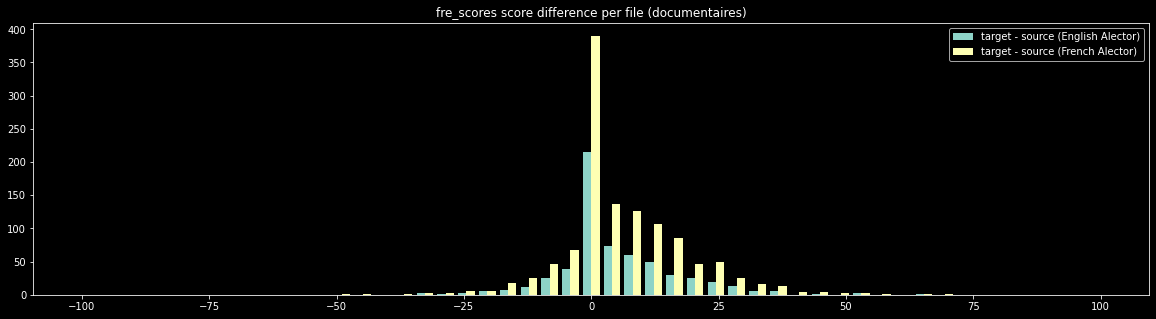

595 ressources
1190 ressources


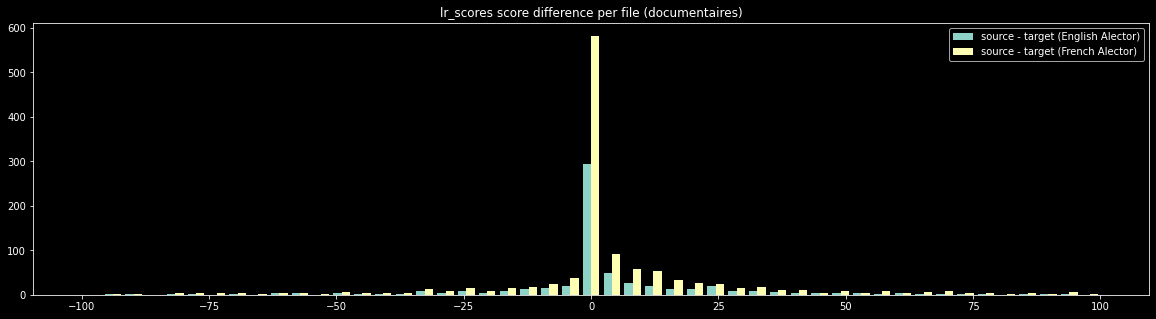

595 ressources
1190 ressources


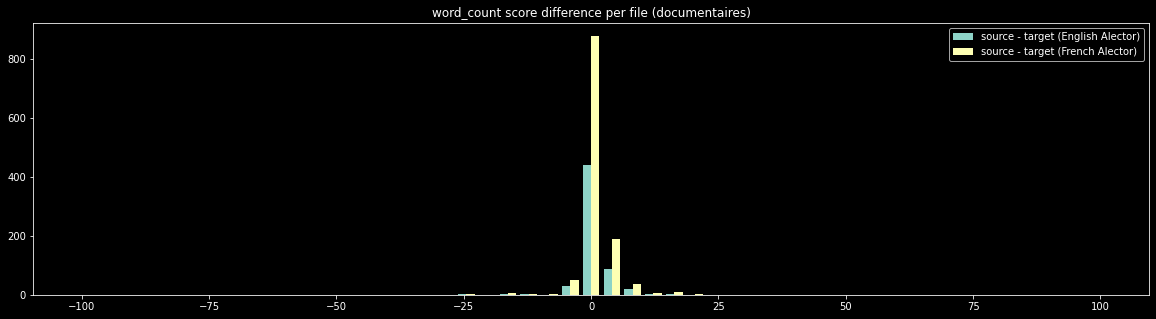

In [38]:
try:
    with open('alector_aligned_metrics.json', 'r') as fp:
        dic_fr = json.load(fp)
except:
    dic_fr = alector()

try:
    with open('EN-alector_aligned_metrics.json', 'r') as fp:
        dic_en = json.load(fp)
except:
    dic_en = alector("EN-alector_aligned")

# text_types = ["contes", "documentaires", "everything"]
text_types = ["documentaires"]

metrics = ["fre_scores", "lr_scores", "word_count"]

for text_type in text_types:
    for metric in metrics:
        alector_plot(dic_en, "English Alector", dic_fr, "French Alector", text_type, metric, numpy.linspace(-100, 100, 50))

#### Translated Datasets Comparisons

##### Loading & Plotting 

In [39]:
def load_dataset(path="translated_corpora/Turk-GEM", lang="en", edit_dist=True):
    src_keywords = ["norm", "orig","src", "source"]
    tar_keywords = ["dst", "turk", "simp", "target"]
    dic = {}
    src_files = []
    tar_files = []

    for element in os.listdir(path):
        for keyword in src_keywords:
            if keyword in element:
                src_files.append(element)
        for keyword in tar_keywords:
            if keyword in element:
                tar_files.append(element)
    
    if edit_dist:
        for src_file in src_files:
            for tar_file in tar_files:
                if tar_file.rsplit(".",2)[:-2] == src_file.rsplit(".",1)[:-1] or tar_file.rsplit(".",1)[:-1] == src_file.rsplit(".",1)[:-1]:
                    edsw, edsc = calculate_edit_distance(
                        os.path.join(path, src_file),
                        os.path.join(path, tar_file)
                    )
                    dic[src_file + "_" + tar_file + "_edit_distance_by_char"] = edsc
                    dic[src_file + "_" + tar_file + "_edit_distance_by_word"] = edsw

    for fname in os.listdir(path):
        fpath = os.path.join(path, fname)
        fre_scores, avg_fre_score, lr_scores, avg_lr_score, word_count, avg_word_count = get_metrics_from_file(fpath, lang)
        dic[fname] = {}
        dic[fname]["fre_scores"] = fre_scores
        dic[fname]["avg_fre_score"] = avg_fre_score
        dic[fname]["lr_scores"] = lr_scores
        dic[fname]["avg_lr_score"] = avg_lr_score
        dic[fname]["word_count"] = word_count
        dic[fname]["avg_word_count"] = avg_word_count

    with open(path.split("/")[-1]+".json", 'w') as fp:
        json.dump(dic, fp)
    
    return dic

In [40]:
def retrieve_data(dic, corpus_type, score, dataset):
    source = []
    target = []

    for key in dic.keys():

        if "edit_distance" not in key:

            if dataset == "wikilarge":
                if corpus_type in key:
                    if key.split(".")[-1] == "src":
                        source = dic[key][score]
                    else:
                        target = dic[key][score]

            elif dataset == "asset" or dataset == "turk":
                if corpus_type in key:
                    if key.split(".")[-1] == "orig" or key.split(".")[-1] == "norm":
                        source = dic[key][score]
                    else:
                        target.append(dic[key][score])

    return source, target
    

def dataset_plot(dic1, dic1name, dic2, dic2name, score, bins, dataset):
    dics = [dic1, dic2]
    dicsname = [dic1name, dic2name]

    plt.figure(figsize=(20,5))
    
    substracted = list()
    labels = list()
    c = 0
    
    for dic, dicname in zip(dics, dicsname):
        if dataset == "wikilarge":
            val_src, val_tar = retrieve_data(dic, "valid", score, dataset)
            test_src, test_tar = retrieve_data(dic, "test", score, dataset)
            train_src, train_tar = retrieve_data(dic, "train", score, dataset)

            src = val_src + test_src + train_src 
            tar = val_tar + test_tar + train_tar

        if dataset == "turk" or dataset == "asset":
            testname = "test"
            if dataset == "turk":
                valname = "tune"
            else:
                valname = "valid"

            val_src, val_tar = retrieve_data(dic, valname, score, dataset)
            test_src, test_tar = retrieve_data(dic, testname, score, dataset)

            for count in range(len(val_tar)):
                val_tar[count] += test_tar[count]

            tar = val_tar 
            src = val_src + test_src
            tar_avg = []
            for i in range(len(tar)):
                for j in range(len(tar[i])):
                    if len(tar_avg) <= j:
                        tar_avg.append([])
                    tar_avg[j].append(tar[i][j])
                    
                    if len(tar_avg[j]) == len(tar):
                        tar_avg[j] = sum(tar_avg[j]) / len(tar)
        
            tar = tar_avg

        substracted.append([])

        if score == "fre_scores":
            for tar_item, src_item in zip(tar, src):
                substracted[c].append(tar_item - src_item)
            labels.append(f"target - source ({dicname})")

        if score == "lr_scores"  or score == "word_count":
            for tar_item, src_item in zip(tar, src):
                substracted[c].append(src_item - tar_item)
            labels.append(f"source - target ({dicname})")
        c += 1
        
    # sns.histplot(substracted, bins=bins, multiple="dodge", stat="count")
    plt.hist(substracted, bins=bins, label = labels, histtype='bar')
    
    plt.legend()
    plt.title(f"{score} score difference per file ({text_type})")
    plt.show()


##### Turk

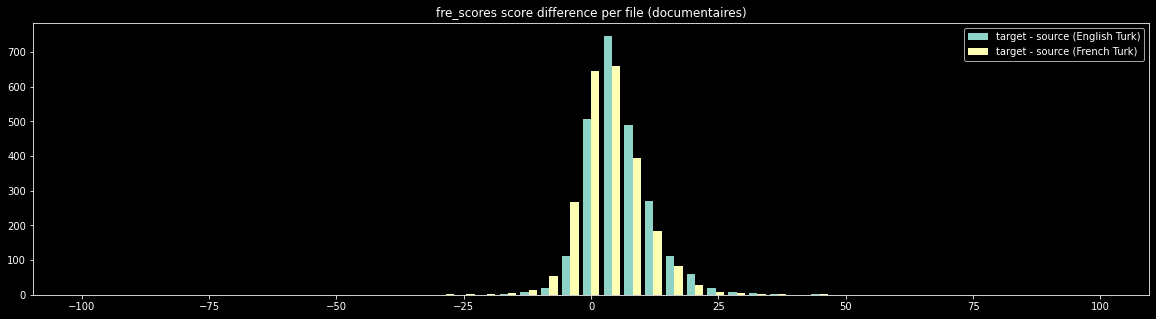

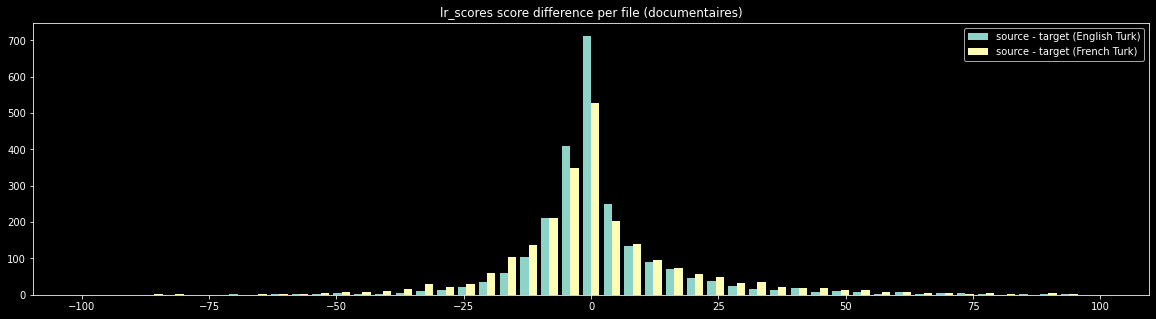

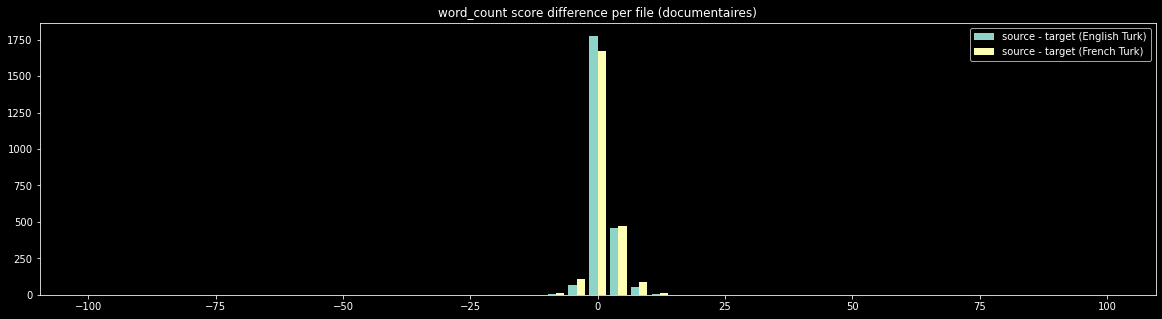

In [41]:
try:
    with open('Turk-GEM.json', 'r') as fp:
        dic_en = json.load(fp)
except:
    dic_en = load_dataset("translated_corpora/Turk-GEM")

try:
    with open('FR-Turk-GEM.json', 'r') as fp:
        dic_fr = json.load(fp)
except:
    dic_fr = load_dataset("translated_corpora/FR-Turk-GEM", 'fr')

metrics = ["fre_scores", "lr_scores", "word_count"]

for metric in metrics:
        dataset_plot(dic_en, "English Turk", dic_fr, "French Turk", metric, numpy.linspace(-100, 100, 50), "turk")


##### ASSET

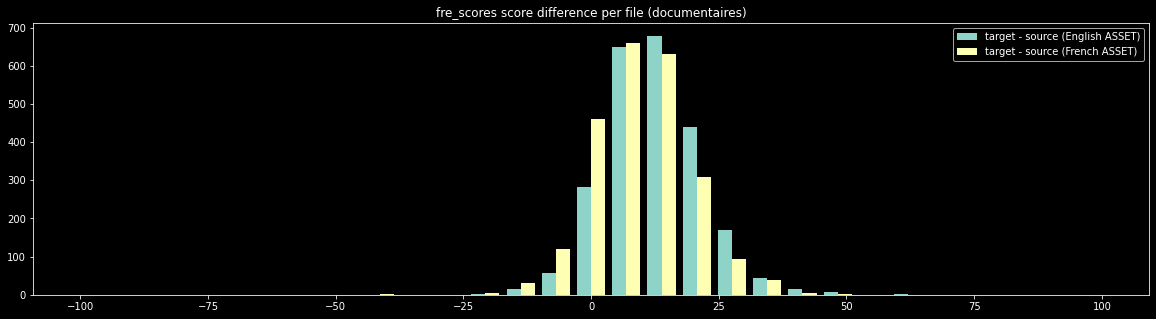

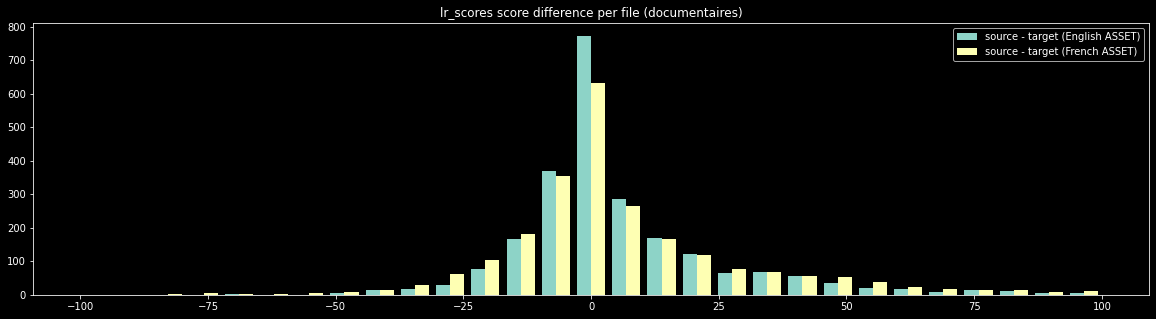

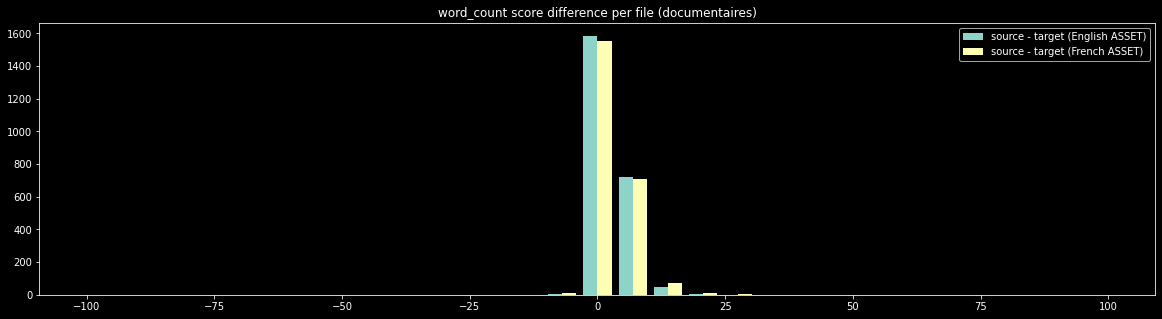

In [42]:
try:
    with open('ASSET.json', 'r') as fp:
        dic_en = json.load(fp)
except:
    dic_en = load_dataset("translated_corpora/ASSET")

try:
    with open('FR-ASSET.json', 'r') as fp:
        dic_fr = json.load(fp)
except:
    dic_fr = load_dataset("translated_corpora/FR-ASSET", 'fr')

for metric in metrics:
        dataset_plot(dic_en, "English ASSET", dic_fr, "French ASSET", metric, numpy.linspace(-100, 100, 30), "asset")

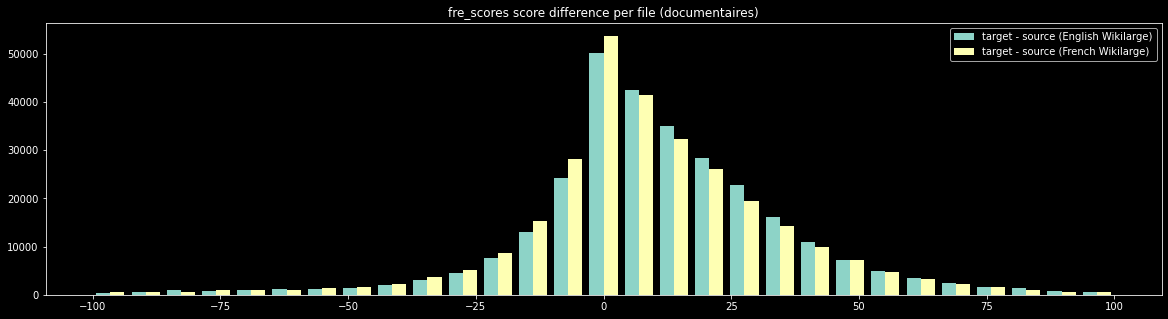

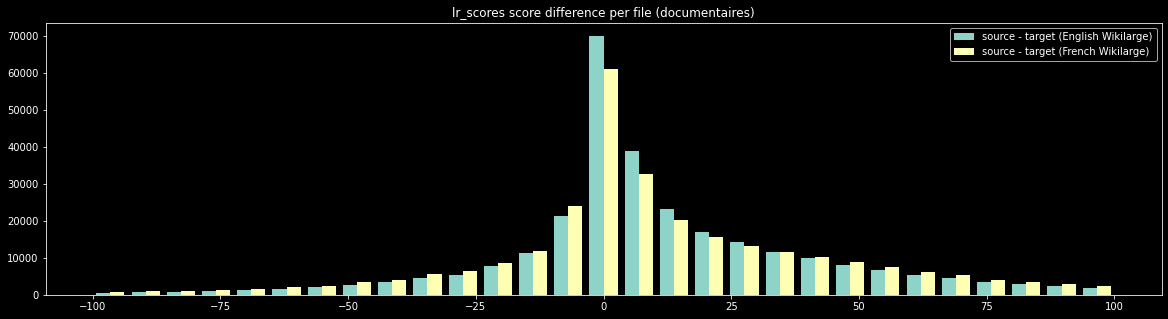

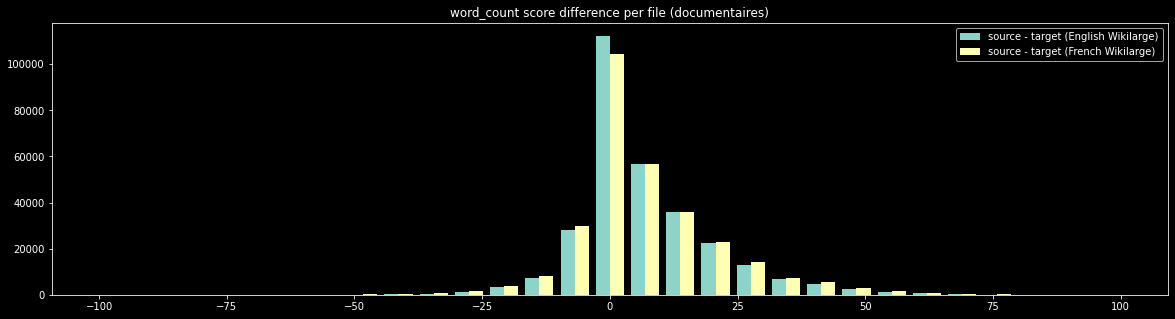

In [43]:
try:
    with open('wikilarge.json', 'r') as fp:
        dic_en = json.load(fp)
except:
    dic_en = load_dataset("translated_corpora/wikilarge")

try:
    with open('FR-wikilarge.json', 'r') as fp:
        dic_fr = json.load(fp)
except:
    dic_fr = load_dataset("translated_corpora/FR-wikilarge", 'fr')

for metric in metrics:
    dataset_plot(dic_en, "English Wikilarge", dic_fr, "French Wikilarge", metric, numpy.linspace(-100, 100, 30), "wikilarge")